# Semester Project - Update 3
## Levi Sprung

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

## Load data

In [141]:
data = pd.read_csv('WR.csv')
data.keys()

Index(['Unnamed: 0', 'playerId', 'recYards', 'combineId', 'combineYear',
       'combinePosition', 'combineHeight', 'combineWeight', 'combineHand',
       'nameFirst', 'nameLast', 'nameFull', 'position', 'collegeId', 'nflId',
       'college', 'heightInches', 'weight', 'dob', 'ageAtDraft',
       'playerProfileUrl', 'homeCity', 'homeState', 'homeCountry',
       'highSchool', 'hsCity', 'hsState', 'hsCountry', 'combineArm',
       'combine40yd', 'combineVert', 'combineBench', 'combineShuttle',
       'combineBroad', 'combine3cone', 'combine60ydShuttle',
       'combineWonderlic', 'draft'],
      dtype='object')

## Filtering
Getting rid of more recently drafted players so that we can minimize players included with incomplete careers

In [144]:
data = data[data['draft'] < 2015]

## Creating features and target
I included the metrics and tests that I wanted to use as targets, and dropped N/A values.

In [183]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

features = ['combineHeight', 'combineWeight', 'combine40yd', 'combineVert', 'combineBench', 
            'combineShuttle', 'combineBroad', 'combine3cone', 'ageAtDraft']
target = 'recYards'

data = data.dropna(subset=features)
data = data.dropna(subset=target)

X = data[features]
y = data[target]

## Target is skewed

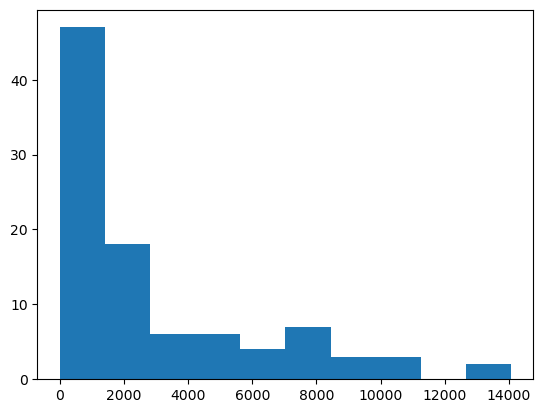

In [212]:
plt.hist(y)
plt.show()

## Transformations
The target is skewed right, so I am trying three different transformations to fix this:
- Log transformation: take the log of the values
- Square root transformation: take the square root of the values 
- Box-cox transformation: essentially transforms a non-normal distribution into a normal distribution

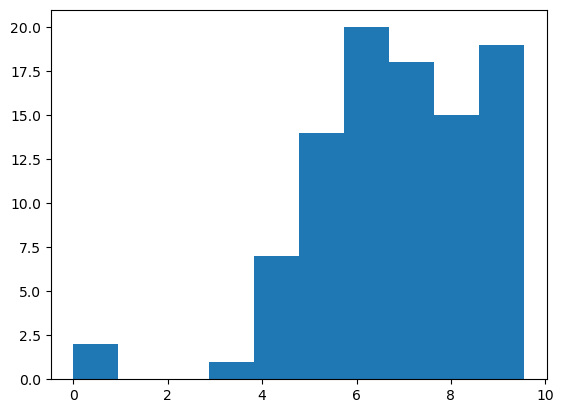

In [184]:
y_log = np.where(y <= 0, 1, y)

y_log = pd.Series(np.log(y_log))

plt.hist(y_log)
plt.show()

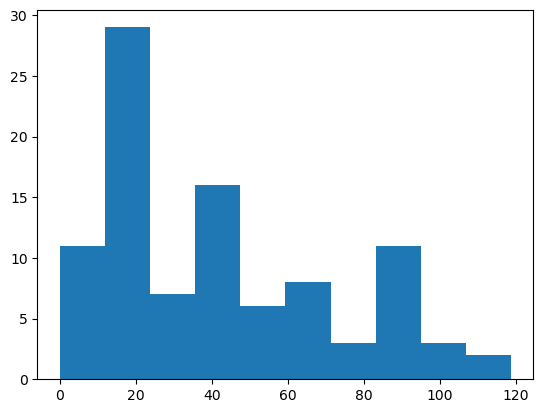

In [185]:
y_sqrt = np.where(y<0, 0, y)
y_sqrt = pd.Series(np.sqrt(y_sqrt))
plt.hist(y_sqrt)
plt.show()

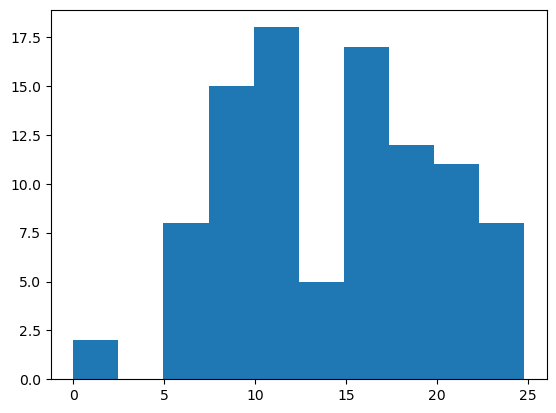

In [186]:
from scipy import stats
y_bc = np.array(np.where(y<=0, 1, y))
y_bc = stats.boxcox(y_bc)
y_bc = pd.Series(y_bc[0])

plt.hist(y_bc)
plt.show()

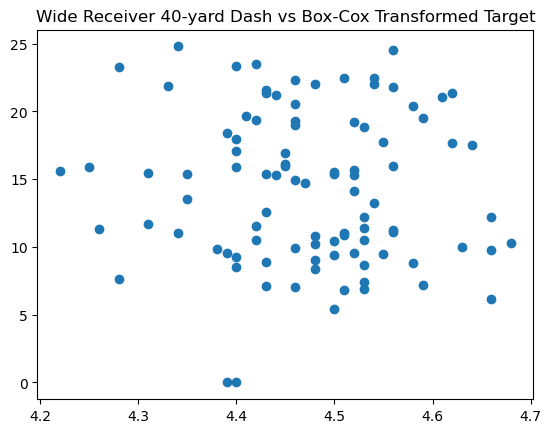

In [218]:
plt.scatter(X['combine40yd'], y_bc)
plt.title("Wide Receiver 40-yard Dash vs Box-Cox Transformed Target")
plt.show()

### Transformation results
Even though the transformations counteracted the skew, it seems like the results still likely won't have a clear correlation with the features.

# Running the models
Models:
- linear regression
- support vector regression with GridSearchCV
- random forest regression with GridSearchCV

Notes:
- I tried multiple transformations for each of the models
- GridSearchCV hyperparameters were not very meticulously selected; mostly just wanted to try multiple things

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bc, test_size=0.3)
lm = LinearRegression()
lm.fit(X_train, y_train)
y_hat = lm.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)

print(f"mse score: {mse}, r-squared score: {r2}")

mse score: 40.09587171903923, r-squared score: -0.31077377076486057


In [161]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.1, 0.01, 0.001],
              'kernel': ['linear', 'rbf', 'poly']}

svr = SVR()
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5)

grid_search.fit(X, y)

print("Best params: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best params:  {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score:  -0.19349220760849256


In [165]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'n_estimators': [100, 400],
             'max_depth':[3, 6, None]}

random_forest = RandomForestRegressor()
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)

grid_search.fit(X, y_bc)

print("Best params: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best params:  {'max_depth': 3, 'n_estimators': 100}
Best score:  -0.09918055047957623


## Visualization: Feature contribution
This is perhaps the most useful information we can glean from the models.

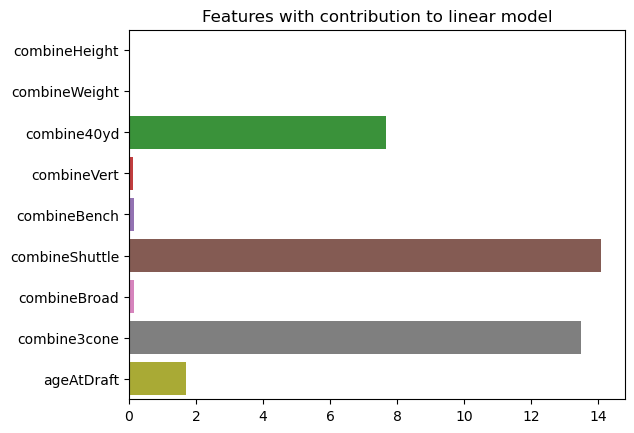

In [195]:
weights = np.abs(lm.coef_)
sns.barplot(x=weights, y=np.array(features))

plt.title('Features with contribution to linear model')
plt.show()

# Results
- Agility tests most predictive, followed by 40-yard dash
- Overall, poor results on the regressions
- Not much of a correlation between features and target for the models to work with

## Future possibilities

- Using college stats
 - Apparently there are some college stats that are said to be fairly predictive of NFL success
 - Such statistics tend to be player stat/team stat (for receiving yards or tackles)
- Athleticism may be more predictive for different positions
- Different measures of success may be easier to use
 - Data with career lengths would be helpful
 - Disregarding the very best performances and looking for a baseline level of success